In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
import pandas as pd
import cmocean.cm as cm
import xscale
import statsmodels.api as sm

%matplotlib inline

In [2]:
fname = '/home/z3526974/Work/data/EAC_altimetry/IMOS_aggregation_whole_system_SSH/IMOS_aggregation_20200316T003045Z.nc'
ds = xr.open_dataset(fname)
# interpolate to daily
ds = ds.resample(TIME='1D').interpolate('linear')

In [3]:
ds = ds.sel(TIME=slice('1993-01-01','2019-12-31'))
ds

<xarray.Dataset>
Dimensions:    (LATITUDE: 86, LONGITUDE: 66, TIME: 9861)
Coordinates:
  * LONGITUDE  (LONGITUDE) float32 147.0 147.2 147.4 147.6 ... 159.6 159.8 160.0
  * LATITUDE   (LATITUDE) float32 -43.0 -42.8 -42.6 -42.4 ... -26.4 -26.2 -26.0
  * TIME       (TIME) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-12-31
Data variables:
    GSLA       (TIME, LATITUDE, LONGITUDE) float64 nan nan nan ... 0.1662 0.1728
    GSL        (TIME, LATITUDE, LONGITUDE) float64 1.921 1.928 ... 2.675 2.683
    UCUR       (TIME, LATITUDE, LONGITUDE) float64 nan nan ... -0.1153 -0.1117
    VCUR       (TIME, LATITUDE, LONGITUDE) float64 nan nan ... -0.144 -0.07824
Attributes:
    History:                        
    institution:                   CSIRO Marine and Atmospheric Research
    project:                       Integrated Marine Observing System (IMOS)
    netcdf_version:                4.0
    platform_code:                 GSLA
    product_type:                  DM00
    naming_authority:     

## Compute EKE and MKE as per Backeberg et al 2012

In [4]:
# MKE and EKE are calculated relative to the annual mean
UCUR_annual = ds.UCUR.groupby('TIME.year').mean('TIME')
VCUR_annual = ds.VCUR.groupby('TIME.year').mean('TIME')
U_prime = ds.UCUR.groupby('TIME.year') - UCUR_annual
V_prime = ds.VCUR.groupby('TIME.year') - VCUR_annual
KE = 0.5*(ds.UCUR**2 + ds.VCUR**2)
EKE = 0.5*(U_prime**2 + U_prime**2)
MKE = 0.5*(UCUR_annual**2 + VCUR_annual**2)
EKE_spat_mean = KE.mean(dim="TIME")
MKE_spat_mean = KE.mean(dim="TIME")

/home/z3526974/anaconda2/envs/py36/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/z3526974/anaconda2/envs/py36/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


## Plot map of mean KE

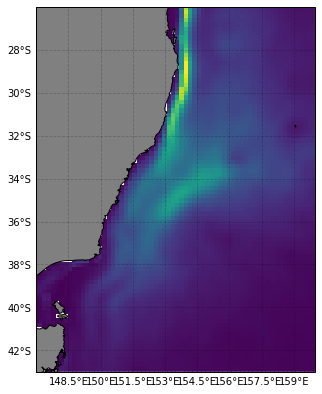

In [5]:
fig = plt.figure(figsize=(5,8))

coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')
roi = [147, 160, -43, -26]
ax2 = plt.axes(projection=ccrs.PlateCarree())
feature = ax2.add_feature(coast, edgecolor='black',facecolor='gray')

im = EKE_spat_mean.plot(transform=ccrs.PlateCarree(),add_colorbar=False)
ax2.set_extent(roi)
gl = ax2.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top = False

In [6]:
mean_EKE = EKE.mean('LATITUDE')
mean_EKE = mean_EKE.mean('LONGITUDE')
mean_MKE = MKE.mean('LATITUDE')
mean_MKE = mean_MKE.mean('LONGITUDE')

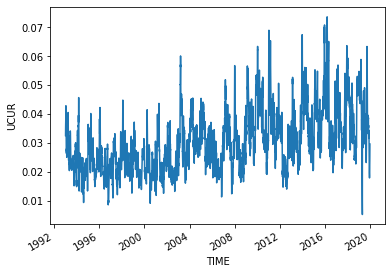

In [7]:
mean_EKE.plot()

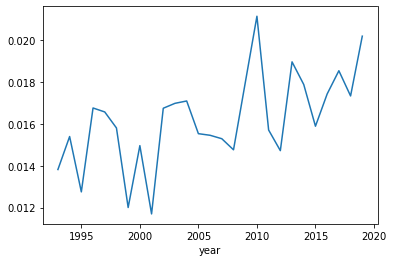

In [8]:
mean_MKE.plot()

In [9]:
plt.rcParams['figure.figsize'] = 11, 4
wt = mean_EKE.window
wt.set(n=730, dim='TIME', window='hanning')
filt_EKE = wt.convolve()

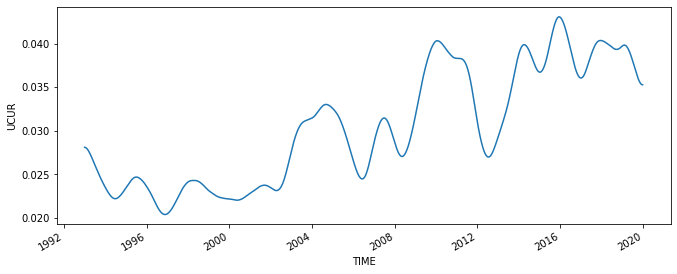

In [10]:
filt_EKE.plot()

In [11]:
mean_EKE

<xarray.DataArray 'UCUR' (TIME: 9861)>
array([0.032624, 0.033158, 0.034691, ..., 0.026529, 0.028048, 0.029692])
Coordinates:
  * TIME     (TIME) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-12-31
    year     (TIME) int64 1993 1993 1993 1993 1993 ... 2019 2019 2019 2019 2019

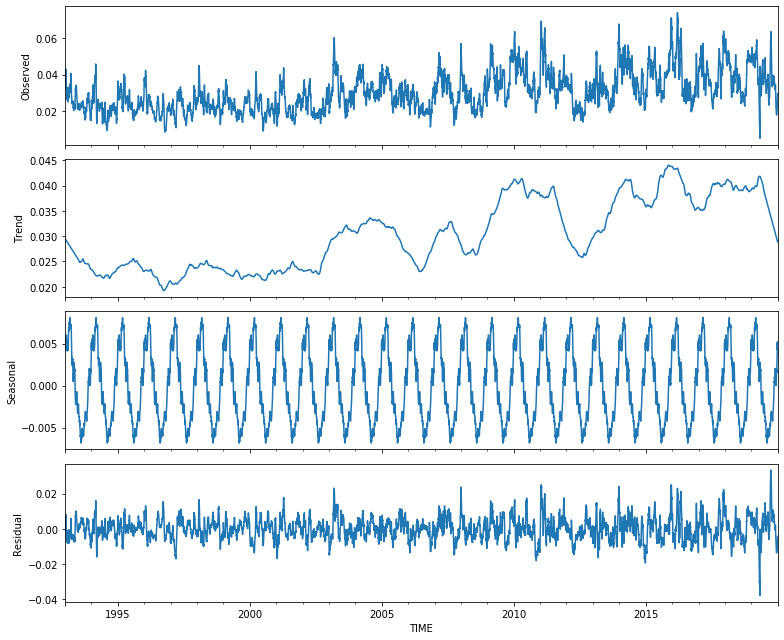

In [12]:
plt.rcParams['figure.figsize'] = 11, 9

y = mean_EKE.to_series()
decomposition = sm.tsa.seasonal_decompose(y, model='additive', freq=365 ,extrapolate_trend=1)
fig = decomposition.plot()
plt.show()

Text(0.5, 1.0, 'EKE area average (150-156E, 30-37S) 2yr filter')

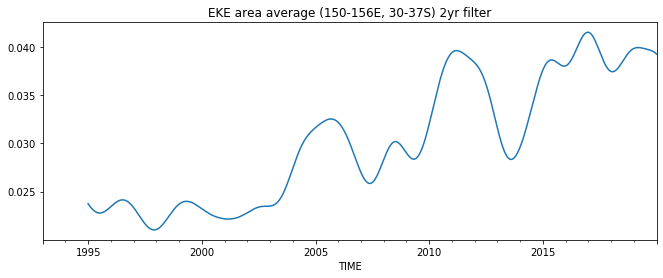

In [13]:
plt.rcParams['figure.figsize'] = 11, 4
annual_trend = decomposition.trend.rolling(730, win_type='hamming').mean().plot()
plt.title('EKE area average (150-156E, 30-37S) 2yr filter')

## Calculate and plot trends and significance level

In [14]:
EKE_annual_means = EKE.groupby('TIME.year').mean('TIME')

year = EKE_annual_means.year
lat = EKE_annual_means.LATITUDE
lon = EKE_annual_means.LONGITUDE

print(np.shape(EKE_annual_means))
EKE_EAC_slope = xr.DataArray(
    np.zeros([np.shape(lat)[0], np.shape(lon)[0]]), 
    dims=('lat', 'lon'), 
    coords=[lat, lon], 
    name='EKE_EAC_slope')

EKE_EAC_p_value = xr.DataArray(
    np.zeros([np.shape(lat)[0], np.shape(lon)[0]]), 
    dims=('lat', 'lon'), 
    coords=[lat, lon], 
    name='EKE_EAC_p_value')

for iid, i in enumerate(lat):
    for jid, j in enumerate(lon):
        EKE_EAC_slope[iid, jid], _, _, EKE_EAC_p_value[iid, jid], _ = \
        stats.linregress(year, EKE_annual_means[:, iid, jid])
    #print('lat ' + str(np.array(i)))
#print(EKE_EAC_slope)

/home/z3526974/anaconda2/envs/py36/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(27, 86, 66)


In [15]:
MKE_annual_means = MKE

year = MKE_annual_means.year
lat = MKE_annual_means.LATITUDE
lon = MKE_annual_means.LONGITUDE

print(np.shape(MKE_annual_means))
MKE_EAC_slope = xr.DataArray(
    np.zeros([np.shape(lat)[0], np.shape(lon)[0]]), 
    dims=('lat', 'lon'), 
    coords=[lat, lon], 
    name='MKE_EAC_slope')

MKE_EAC_p_value = xr.DataArray(
    np.zeros([np.shape(lat)[0], np.shape(lon)[0]]), 
    dims=('lat', 'lon'), 
    coords=[lat, lon], 
    name='MKE_EAC_p_value')

for iid, i in enumerate(lat):
    for jid, j in enumerate(lon):
        MKE_EAC_slope[iid, jid], _, _, MKE_EAC_p_value[iid, jid], _ = \
        stats.linregress(year, MKE_annual_means[:, iid, jid])
    #print('lat ' + str(np.array(i)))
#print(MKE_EAC_slope)

(27, 86, 66)


## Make a pretty plot with crosshatching for significance

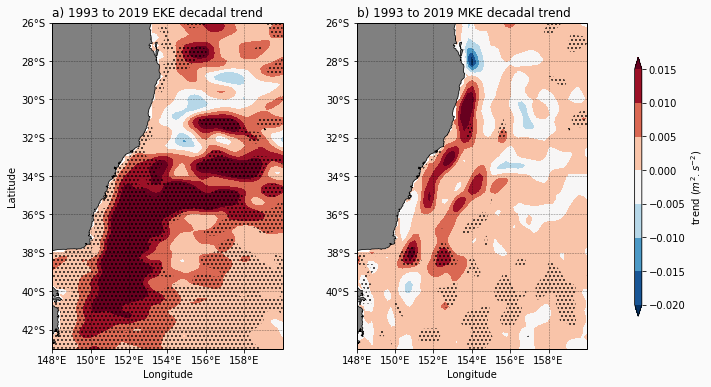

In [16]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

roi = [148, 160, -43, -26]

land_50m= cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    edgecolor='black',
                                    facecolor='gray',
                                    linewidth=0.75)

fig = plt.figure(1, figsize=(10,6), facecolor=[0.98,0.98,0.98]) 

ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent(roi)

levels=np.arange(-0.02,0.02,0.005)
cmap = plt.cm.RdBu_r
data = EKE_EAC_slope * 10
plot = plt.contourf(data.lon, data.lat, data,
            cmap=cmap, levels=levels, extend='both', transform=ccrs.PlateCarree())

levels2=[0, 0.05]
data2 = EKE_EAC_p_value
plot2 = plt.contourf(data.lon, data.lat, data2, hatches=['...'],
            colors='none', levels=levels2, transform=ccrs.PlateCarree())

ax1.set_title('a) 1993 to 2019 EKE decadal trend', loc='left')

ax1.set_xticks(np.arange(148, 160, 2), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(-26, -43, -2), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')


ax1.grid(linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax1.add_feature(land_50m)


ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent(roi)

levels=np.arange(-0.02,0.02,0.005)
cmap = plt.cm.RdBu_r
data = MKE_EAC_slope * 10
plot = plt.contourf(data.lon, data.lat, data,
            cmap=cmap, levels=levels, extend='both', transform=ccrs.PlateCarree())

levels2=[0, 0.05]
data2 = MKE_EAC_p_value
plot2 = plt.contourf(data.lon, data.lat, data2, hatches=['...'],
            colors='none', levels=levels2, transform=ccrs.PlateCarree())

ax2.set_title('b) 1993 to 2019 MKE decadal trend', loc='left')

ax2.set_xticks(np.arange(148, 160, 2), crs=ccrs.PlateCarree())
ax2.set_yticks(np.arange(-26, -42, -2), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.set_xlabel('Longitude')
#ax2.set_ylabel('Latitude')


ax2.grid(linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax2.add_feature(land_50m)

cbar_ax = fig.add_axes([.95, 0.2, .01, .6]) #left, bottom, width, height
fig.colorbar(plot, cax=cbar_ax, orientation="vertical",extend='both')
plt.ylabel('trend ($m^{2}.s^{-2}$)')
plt.savefig('EAC_MKE_EKE_trends.png', dpi=300,bbox_inches='tight')

In [17]:
pwd

'/home/z3526974/Work/code/Shelf_moorings'

# need to calculate skewness as per Oliver & Holbrook 2014

Text(0, 0.5, 'skewness')

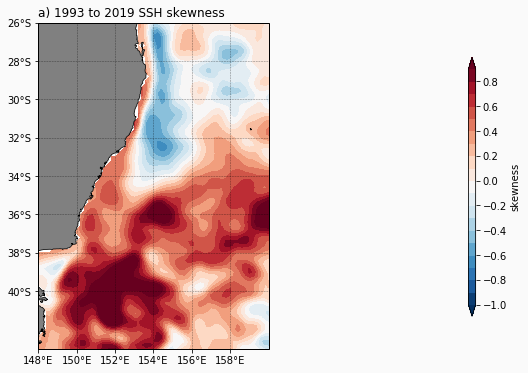

In [18]:
SSH_skewness = stats.skew(ds.GSLA)

fig = plt.figure(1, figsize=(10,6), facecolor=[0.98,0.98,0.98]) 
ax1 = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax1.set_extent(roi)
levels=np.arange(-1,1,.1)
plot = plt.contourf(data.lon, data.lat, SSH_skewness,
            cmap=cmap, extend='both', levels=levels, transform=ccrs.PlateCarree())


ax1.set_title('a) 1993 to 2019 SSH skewness', loc='left')

ax1.set_xticks(np.arange(148, 160, 2), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(-26, -42, -2), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax2.set_xlabel('Longitude')
#ax1.set_ylabel('Latitude')


ax1.grid(linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax1.add_feature(land_50m)

cbar_ax = fig.add_axes([.95, 0.2, .01, .6]) #left, bottom, width, height
fig.colorbar(plot, cax=cbar_ax, orientation="vertical",extend='both')
plt.ylabel('skewness')

## Now lets calculate the skewness for each year

In [19]:
ssh_yearly = ds.GSLA.groupby('TIME.year')
#test = stats.skew(ssh_yearly.all)

## Looks like there is a dividing line in EKE at 33S, lets divide up the domain and make timeseries north and south of this

In [20]:
EKE_S = EKE.sel(LATITUDE=slice(-40, -32)).mean(dim = {'LATITUDE', 'LONGITUDE'})
EKE_N = EKE.sel(LATITUDE=slice(-32, -26)).mean(dim = {'LATITUDE', 'LONGITUDE'})

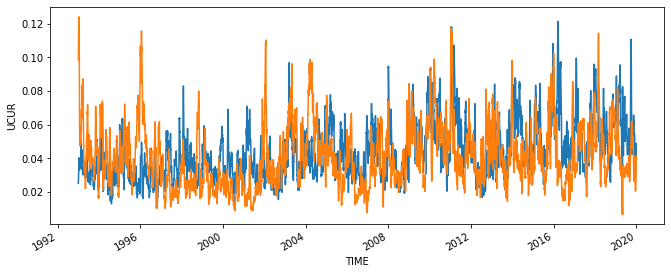

In [21]:
EKE_S.plot()
EKE_N.plot()

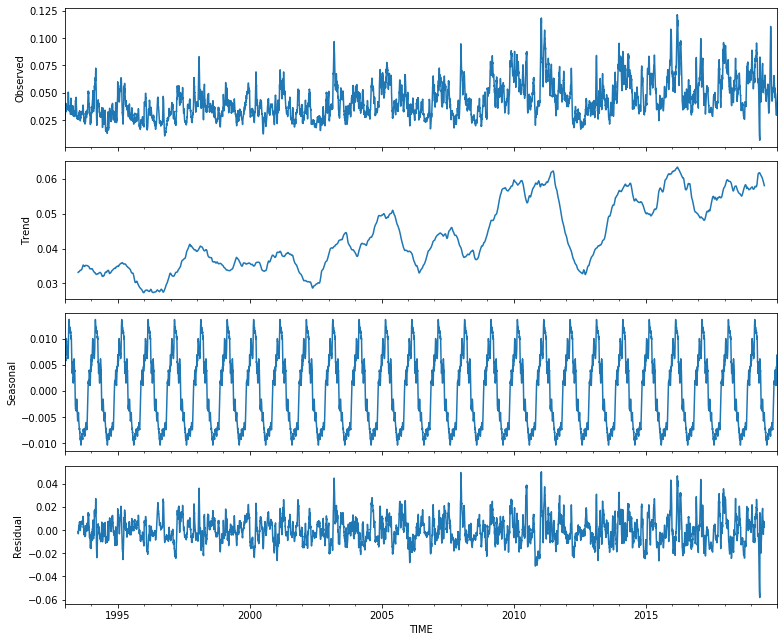

In [22]:
plt.rcParams['figure.figsize'] = 11, 9

ys = EKE_S.to_series()
decomposition_S = sm.tsa.seasonal_decompose(ys, model='additive', freq=365 ,extrapolate_trend=0)
fig = decomposition_S.plot()
plt.show()

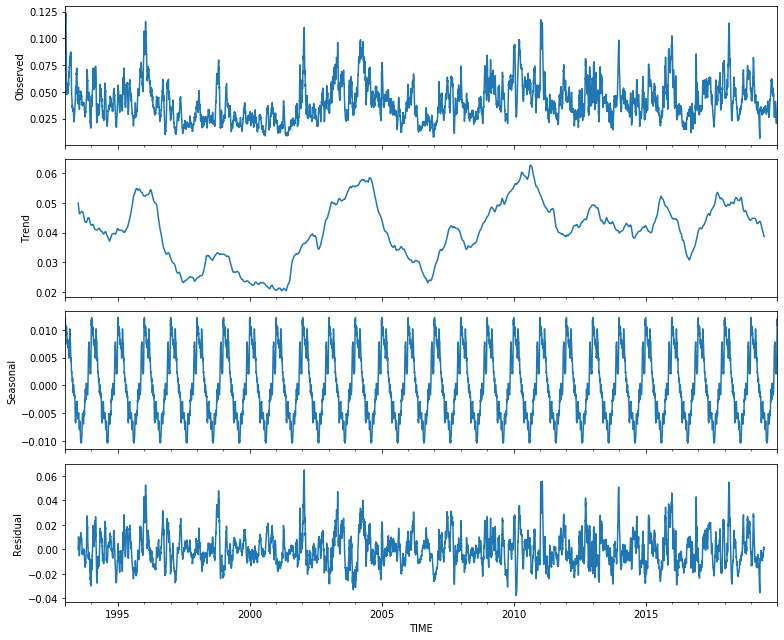

In [23]:
plt.rcParams['figure.figsize'] = 11, 9

yn = EKE_N.to_series()
decomposition_N = sm.tsa.seasonal_decompose(yn, model='additive', freq=365 ,extrapolate_trend=0)
fig = decomposition_N.plot()
plt.show()

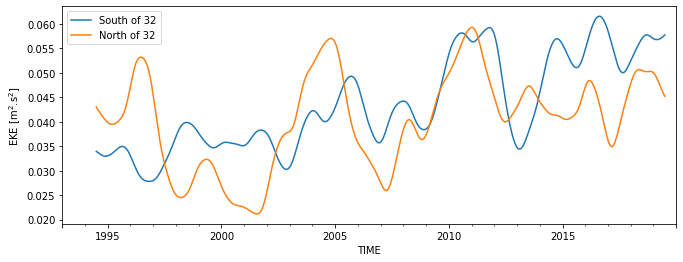

In [24]:
plt.rcParams['figure.figsize'] = 11, 4
decomposition_S.trend.rolling(365, win_type='hamming').mean().plot(label='South of 32')
decomposition_N.trend.rolling(365, win_type='hamming').mean().plot(label='North of 32')
plt.legend()
plt.ylabel('EKE [m$^2$.s$^2$]')
plt.savefig('EAC_EKE_N_S_timeseries.png', dpi=300,bbox_inches='tight')

In [25]:
EKE_S_filtered = decomposition_S.trend.rolling(365, win_type='hamming').mean()
%store EKE_S_filtered
EKE_N_filtered = decomposition_N.trend.rolling(365, win_type='hamming').mean()
%store EKE_N_filtered

Stored 'EKE_S_filtered' (Series)
Stored 'EKE_N_filtered' (Series)


## Extract coastal box for Amandine

In [26]:
EKE_Abox = EKE.sel(LATITUDE=slice(-36, -32), LONGITUDE=slice(150, 154)).mean(dim = {'LATITUDE', 'LONGITUDE'})
EKE_Abox_annual = EKE_Abox.groupby('TIME.year').mean('TIME')
MKE_Abox = MKE.sel(LATITUDE=slice(-36, -32), LONGITUDE=slice(150, 154)).mean(dim = {'LATITUDE', 'LONGITUDE'})

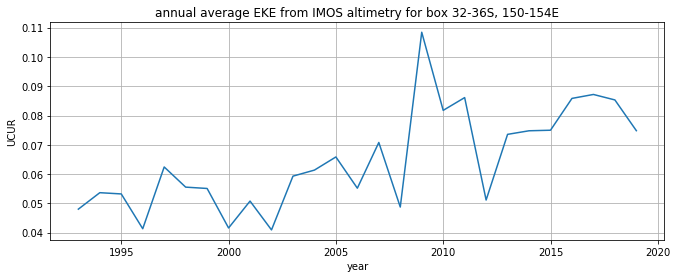

In [27]:
EKE_Abox_annual.plot()
plt.grid(True)
plt.title('annual average EKE from IMOS altimetry for box 32-36S, 150-154E')
plt.savefig('Ann_average_EKE_32_36S_150_154E.png', dpi=300,bbox_inches='tight')

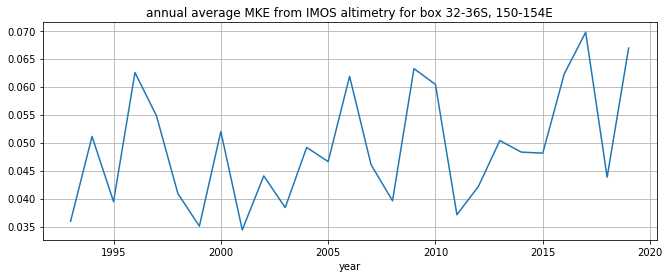

In [28]:
MKE_Abox.plot()
plt.grid(True)
plt.title('annual average MKE from IMOS altimetry for box 32-36S, 150-154E')
plt.savefig('Ann_average_MKE_32_36S_150_154E.png', dpi=300,bbox_inches='tight')